<h1>ATM Next 5-days Amounts Prediction </h1>

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn import preprocessing
import glob
import string
import scipy.stats as stats
from datetime import timedelta

# for visualization
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# for model building
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import category_encoders as ce
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics
from sklearn.svm import SVC, NuSVC
from sklearn.model_selection import train_test_split
import imblearn
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pmdarima as pm
from math import sqrt, isnan
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.options.display.max_rows = 200
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

# - Import Dataset

In [2]:
missing_values = ["n/a", "na", "--", "", "XNA", "Unknown", "unknown"]
db = pd.read_csv("atms_data.csv", na_values=missing_values)
db.rename({'Amount                                                                   ':'Amount'}, axis=1, inplace=True)
print("Shape of application data: ", db.shape)

Shape of application data:  (573119, 6)


In [181]:
db.head()

,Unnamed: 0,Date,ATM ID,Number of Trxs,Amount,capacity
0,0,20180201,3479212,199,235250,NaN
1,1,20180201,1599756,105,237300,NaN
2,2,20180201,2019227,487,539910,720000.0
3,3,20180201,3200101,354,466900,NaN
4,4,20180201,5129042,224,432610,NaN


In [182]:
db.drop(['Unnamed: 0'], axis=1, inplace=True)
print("Shape of application data: ", db.shape)

Shape of application data:  (573119, 5)


In [183]:
db.describe().applymap(lambda x: f'{x:.0f}' if isinstance(x, (int, float)) else x)

/var/folders/kw/dchp08qs3lqgjzpc8kwkl5xr0000gn/T/ipykernel_2585/613877983.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.

  db.describe().applymap(lambda x: f'{x:.0f}' if isinstance(x, (int, float)) else x)


,Date,ATM ID,Number of Trxs,Amount,capacity
count,573119,573119,573119,573119,143996
mean,20180755,3060311,136,207860,927726
std,332,1313341,119,208996,192866
min,20180201,1009104,1,10,530000
25%,20180513,2019374,46,56610,740000
50%,20180722,3050455,106,148550,900000
75%,20181029,4009450,192,290745,940000
max,20181231,7089115,1183,2508470,1700000


In [184]:
db['Date'] = pd.to_datetime(db['Date'], format='%Y%m%d')
db.head()

,Date,ATM ID,Number of Trxs,Amount,capacity
0,2018-02-01,3479212,199,235250,NaN
1,2018-02-01,1599756,105,237300,NaN
2,2018-02-01,2019227,487,539910,720000.0
3,2018-02-01,3200101,354,466900,NaN
4,2018-02-01,5129042,224,432610,NaN


In [185]:
db.drop(['capacity'], axis=1, inplace=False).head()

,Date,ATM ID,Number of Trxs,Amount
0,2018-02-01,3479212,199,235250
1,2018-02-01,1599756,105,237300
2,2018-02-01,2019227,487,539910
3,2018-02-01,3200101,354,466900
4,2018-02-01,5129042,224,432610


<h1>EDA</h1>

## - Data Shape

The ATMs dataset consists of 573119 observations, and 5 features.


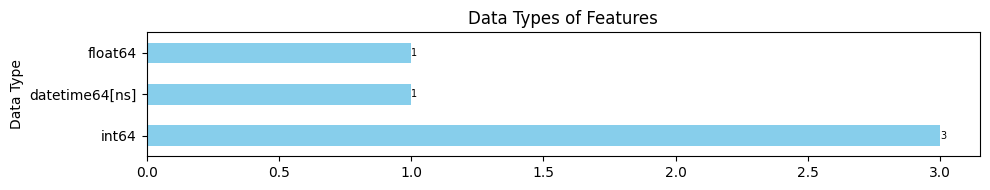

In [186]:
# Plot the first subplot
dTypesCount = db.dtypes.value_counts()
print(f"The ATMs dataset consists of {db.shape[0]} observations, and {db.shape[1]} features.")

dTypesCount.plot(kind='barh', color='skyblue',figsize=(10,2))
for index, value in enumerate(dTypesCount):
    plt.text(value, index, str(value), ha='left', va='center', fontsize=7)
plt.title("Data Types of Features")
plt.ylabel("Data Type")
plt.tight_layout()
plt.show()

## - Missing Values Percentage Per Column


Number of columns with missing values in the application dataset: 1 out of 5, with missing percentage of 74.88%


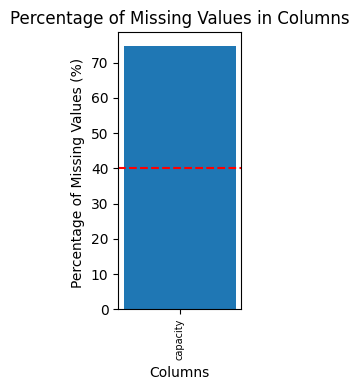

In [187]:
total = db.shape[0]

missing_in_col_cnt = {}
missing_in_col_per = {}
for col in db.columns:
    missing_in_col_cnt[col] = db[col].isnull().sum()
    missing_in_col_per[col] = (missing_in_col_cnt[col] / total) * 100

# Filter out columns with zero missing values
columns_with_missing = {col: percent for col, percent in missing_in_col_per.items() if percent > 0}

print(f"Number of columns with missing values in the application dataset: {len(columns_with_missing)} out of {len(db.columns)}, with missing percentage of {np.mean(list(columns_with_missing.values())):.2f}%")
x = columns_with_missing.keys()
y = columns_with_missing.values()
plt.figure(figsize=(2, 4))
plt.bar(x, y)
plt.xticks(rotation='vertical', fontsize = 7)

plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Values (%) ')
plt.title('Percentage of Missing Values in Columns')
plt.axhline(40, ls='--',color='red')
plt.tight_layout()
plt.show()

<p style="color:green">- Capacity is the only column with missing values, 75% missing. </p>

## - Total Transactions Count per day

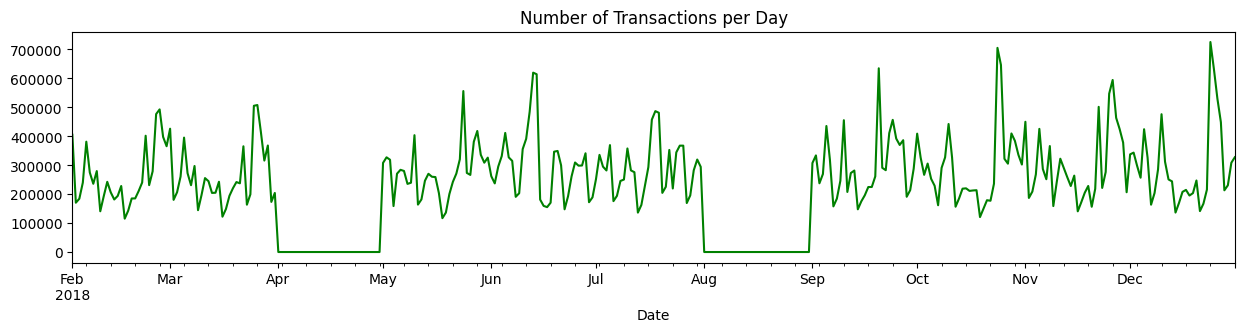

In [188]:
trx_per_day = db.groupby(pd.Grouper(key='Date',axis = 0, freq='d'))['Number of Trxs'].sum()
plot = trx_per_day.plot(figsize=(15, 3), title='Number of Transactions per Day', color='green')
# plt.xticks(rotation='vertical')

plt.show()

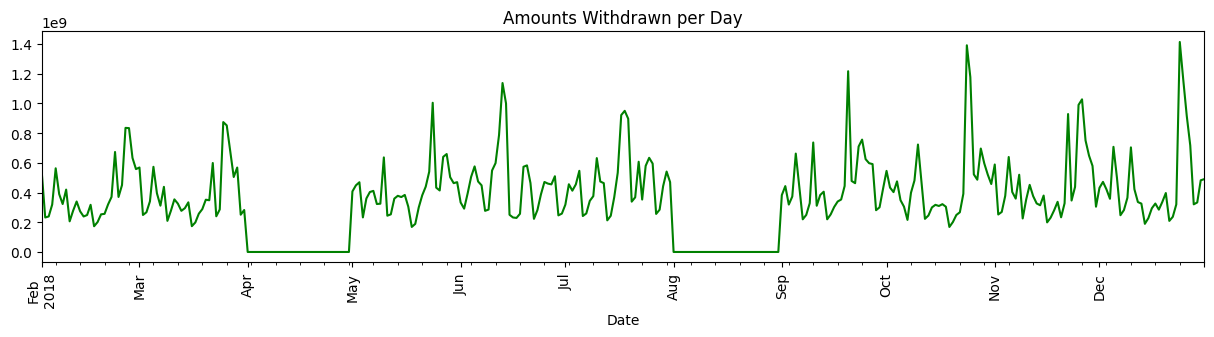

In [189]:
trx_per_day = db.groupby(pd.Grouper(key='Date',axis = 0, freq='d'))['Amount'].sum()
plot = trx_per_day.plot(figsize=(15, 3), title='Amounts Withdrawn per Day', color='green')
plt.xticks(rotation='vertical')

plt.show()

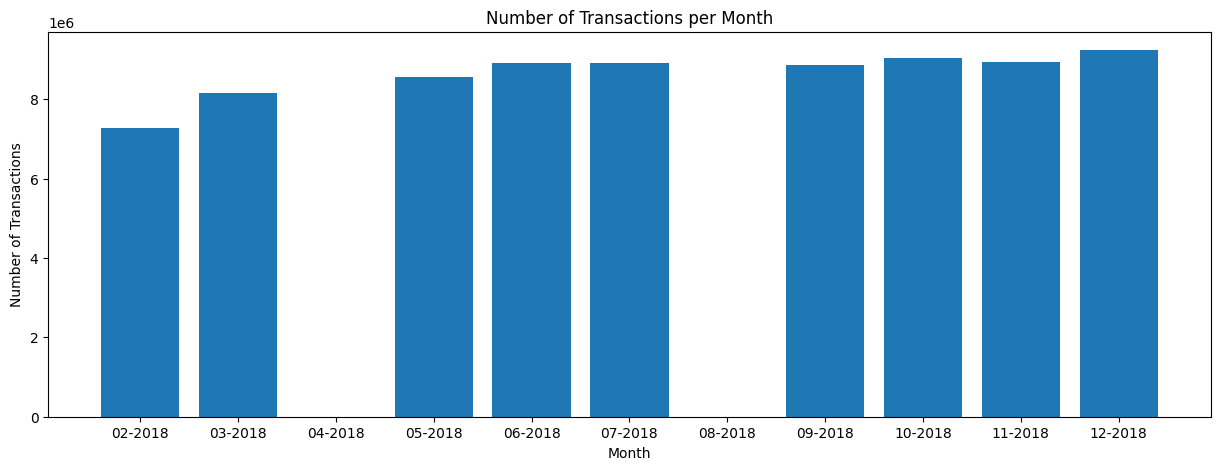

In [190]:
monthly_trx_cnt = db.groupby(pd.Grouper(key='Date', axis=0, freq='M')).sum()['Number of Trxs']
plt.figure(figsize=(15, 5))
plt.bar(monthly_trx_cnt.index.strftime("%m-%Y") , monthly_trx_cnt.values)
plt.title('Number of Transactions per Month')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.show()

[199 105 487 ...   6   6   2]


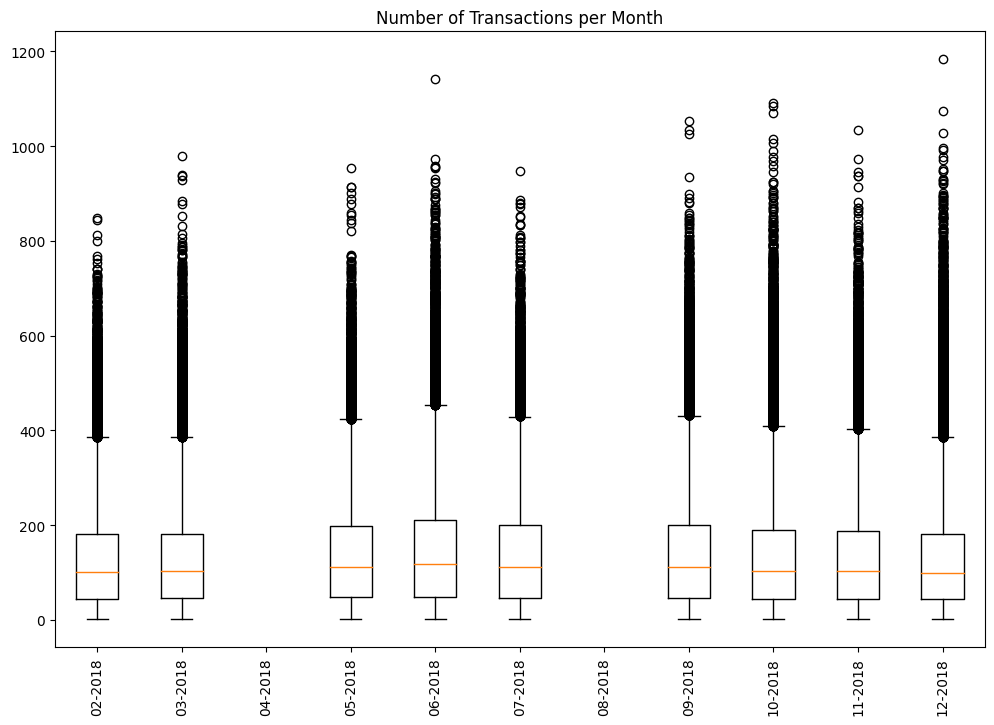

In [191]:
monthly_trx_cnt = db.groupby(pd.Grouper(key='Date', freq='M'))['Number of Trxs']

monthly_trx = {}
for name, group in monthly_trx_cnt:
    monthly_trx[name.strftime("%m-%Y")] = group.values

print((monthly_trx['02-2018']))

plt.boxplot(list(monthly_trx.values()), labels=list(monthly_trx.keys()), vert=True)
plt.xticks(rotation='vertical')
plt.title('Number of Transactions per Month')
plt.show()

## - Check ATM ID uniqueness

In [192]:
atms_cnt = db['ATM ID'].nunique()
no_capacity_cnt = (db.groupby('ATM ID')['capacity'].nunique()==0).astype(int).sum()
single_capacity_cnt = (db.groupby('ATM ID')['capacity'].nunique()==1).astype(int).sum()
multiple_capacity_cnt = (db.groupby('ATM ID')['capacity'].nunique()>1).astype(int).sum()
print(f"Number of ATMs: {atms_cnt}")
print(f"Number of ATMs with no capacity: {no_capacity_cnt}")
print(f"Number of ATMs with single capacity: {single_capacity_cnt}")
print(f"Number of ATMs with multiple capacities: {multiple_capacity_cnt}")
# print(db.groupby('ATM ID')['ATM ID','capacity'].head())


Number of ATMs: 2694

Number of ATMs with no capacity: 1981

Number of ATMs with single capacity: 713

Number of ATMs with multiple capacities: 0


# - Choosing 1 ATM for our analysis

- Check ATMs with highest number of records

In [193]:
atms = db['ATM ID'].value_counts().sort_values(ascending=False)
print(f"Highest number of transactions of an ATM: {atms.iloc[0]}")
atms = atms[atms == atms.iloc[0]]
print(f"Number of ATMs with {atms.iloc[0]} transactions: {atms.count()}")

Highest number of transactions of an ATM: 273

Number of ATMs with 273 transactions: 64


- Filter dataset to only include records of ATMs with the highest number of records

In [194]:
filtered_df = db[db['ATM ID'].isin(atms.index.values.tolist())].copy()
filtered_df.head()
filtered_df.drop('capacity',inplace=True,axis=1)
filtered_df.duplicated().sum()
print(f"Number of duplicated rows: {filtered_df.duplicated().sum()}")

Number of duplicated rows: 0


- Find ATM with highest average number of txns

In [195]:
highest_txns_mean = filtered_df.groupby('ATM ID')['Number of Trxs'].mean().sort_values(ascending=False)
print(highest_txns_mean.head())
print(f"**** ATM ID with highest average transactions: {highest_txns_mean.index[0]}, we will work on this ATM.")
atm_data = filtered_df[filtered_df['ATM ID']==highest_txns_mean.index[0]].copy()

ATM ID

2079266    332.109890

1420352    281.952381

2560448    269.787546

2429026    265.271062

2560425    261.095238

Name: Number of Trxs, dtype: float64

**** ATM ID with highest average transactions: 2079266, we will work on this ATM.


In [196]:
atm_data.drop(['ATM ID','Number of Trxs'],inplace=True,axis=1)
atm_data.set_index('Date',inplace=True)
print(atm_data.shape)
print(atm_data.head())

(273, 1)

            Amount

Date              

2018-02-01  852790

2018-02-02  164000

2018-02-03  293970

2018-02-04  493650

2018-02-05  624720


# - Handling missing values

### - Linear Interpolation

- Create new dataframe containing the complete date range then match it with the missing dataset

In [197]:
complete_df = pd.DataFrame({'Date': pd.date_range(start=atm_data.index.values.min(), end=atm_data.index.values.max(), freq='D')})
merged_df = pd.merge(complete_df, atm_data, on='Date', how='left')
merged_df.set_index('Date', inplace=True)
merged_df.index.freq = 'D'
print(f"Number of rows in the complete dataset: {merged_df.shape[0]}, from {pd.to_datetime(merged_df.index.values.min()).strftime('%d-%m-%Y')} to {pd.to_datetime(merged_df.index.values.max()).strftime('%d-%m-%Y')} ")

Number of rows in the complete dataset: 334, from 01-02-2018 to 31-12-2018 


In [198]:
linear_interpolated_df = merged_df.interpolate(method='linear')

### - Average DOM

In [199]:
dom_interpolated_df = merged_df.copy()
dom_interpolated_df['day'] = dom_interpolated_df.index.day
avgs = merged_df.groupby(merged_df.index.day).mean()['Amount']
for day in avgs.index:
    dom_interpolated_df.loc[dom_interpolated_df['day']==day, 'Amount'] = dom_interpolated_df.loc[dom_interpolated_df['day']==day, 'Amount'].fillna(avgs[day])
dom_interpolated_df.drop('day', axis=1, inplace=True)

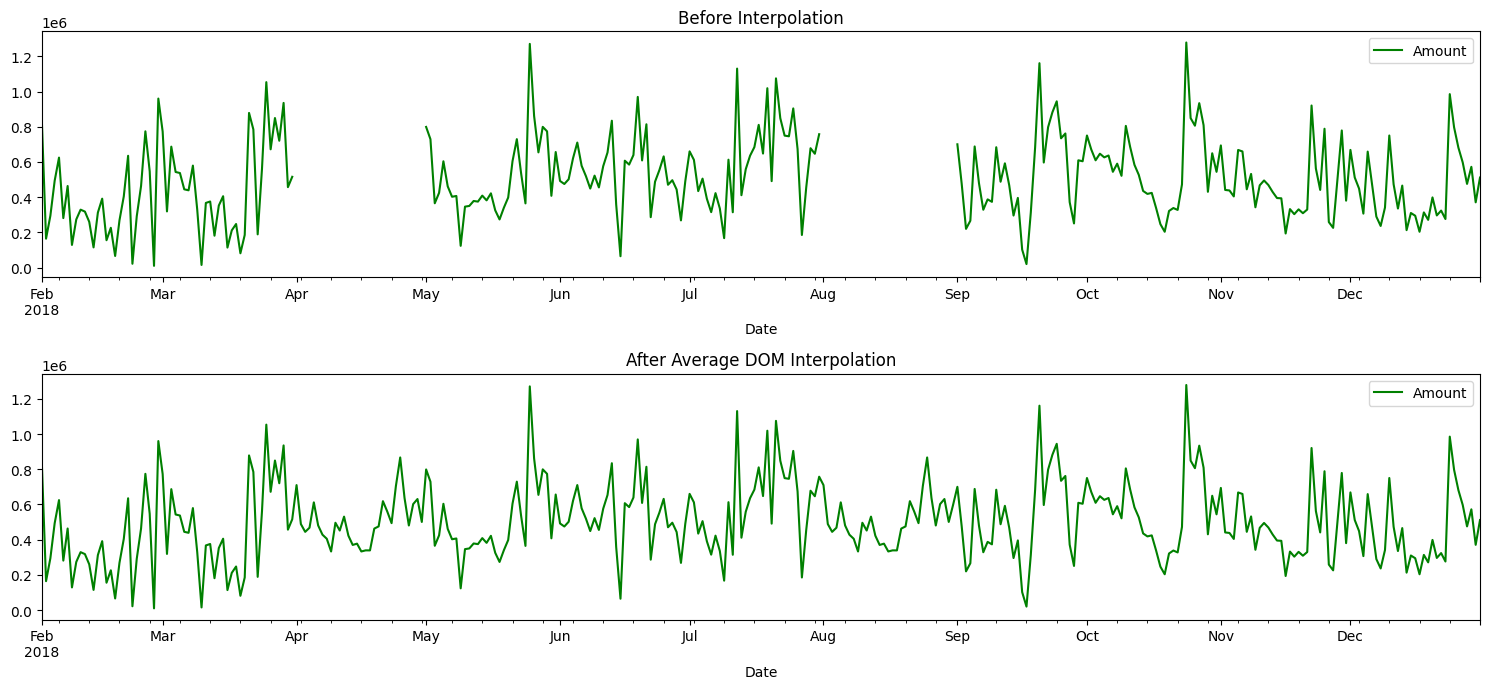

In [200]:
ax, fig = plt.subplots(2, 1, figsize=(15, 7))
merged_df.plot(ax=fig[0], title='Before Interpolation', color='green')
# linear_interpolated_df.plot(ax=fig[1], title='After Linear Interpolation', color='green')
dom_interpolated_df.plot(ax=fig[1], title='After Average DOM Interpolation', color='green')
plt.tight_layout()
plt.xlabel('Date')
plt.show()


In [201]:
dom_interpolated_df.to_csv('dom_interpolated_df.csv')

## - STL Decomposition

- Additive

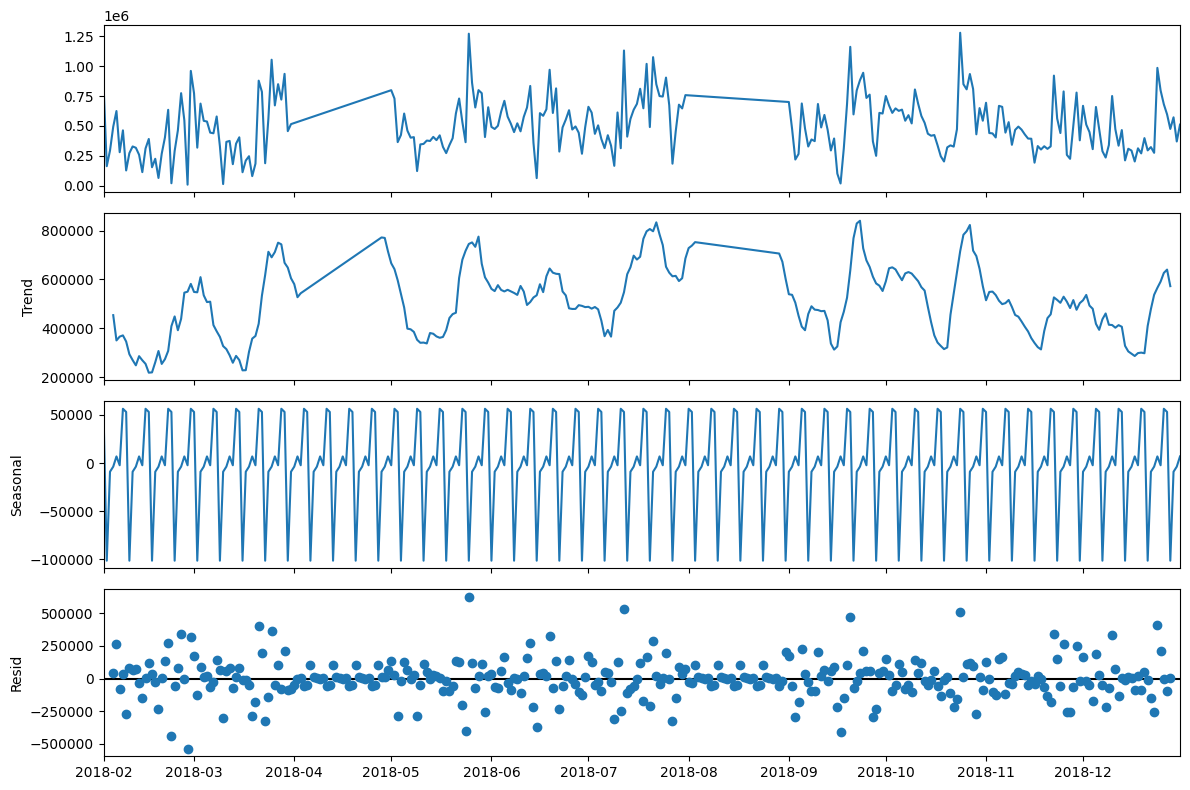

In [202]:
plt.rc('figure',figsize=(12,8))
plt.rc('font',size=10)
result = sm.tsa.seasonal_decompose(linear_interpolated_df.fillna(0),model='additive')
fig = result.plot()

- Multiplicative

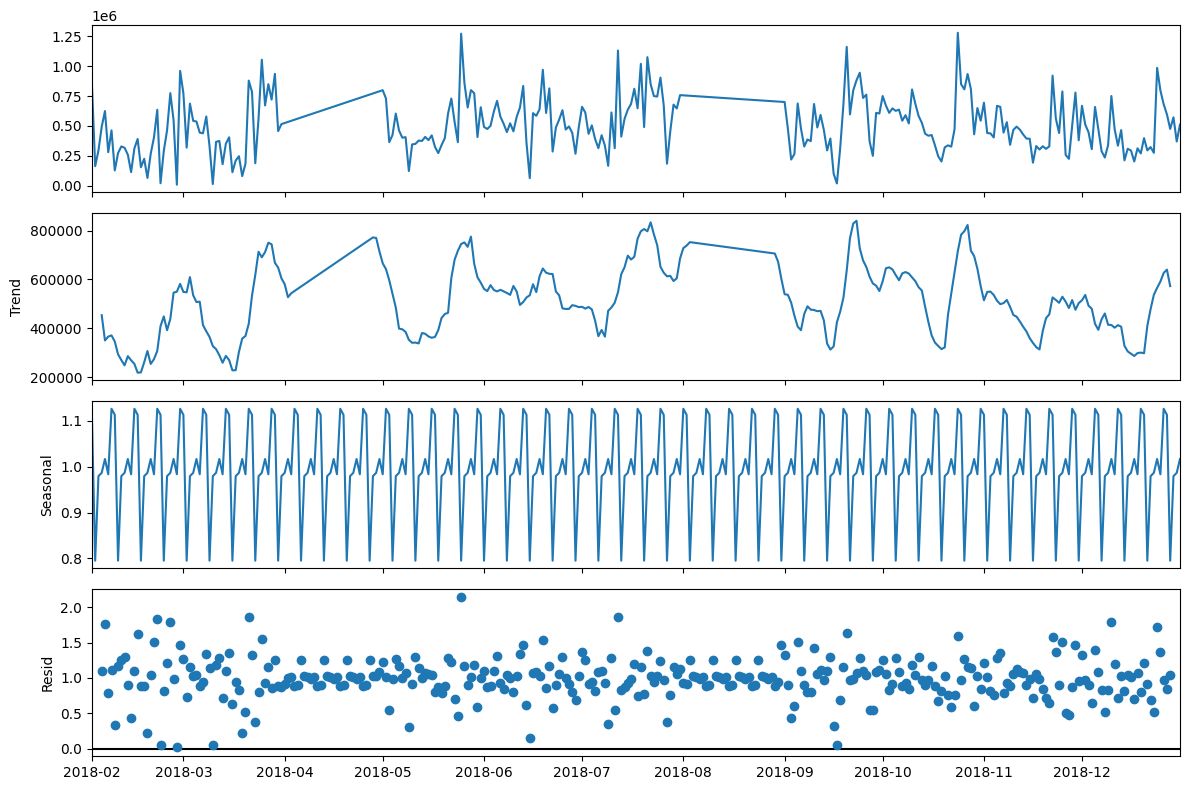

In [203]:
plt.rc('figure',figsize=(12,8))
plt.rc('font',size=10)
result = sm.tsa.seasonal_decompose(linear_interpolated_df.fillna(0),model='multiplicative')
fig = result.plot()

## - ACF, PACF

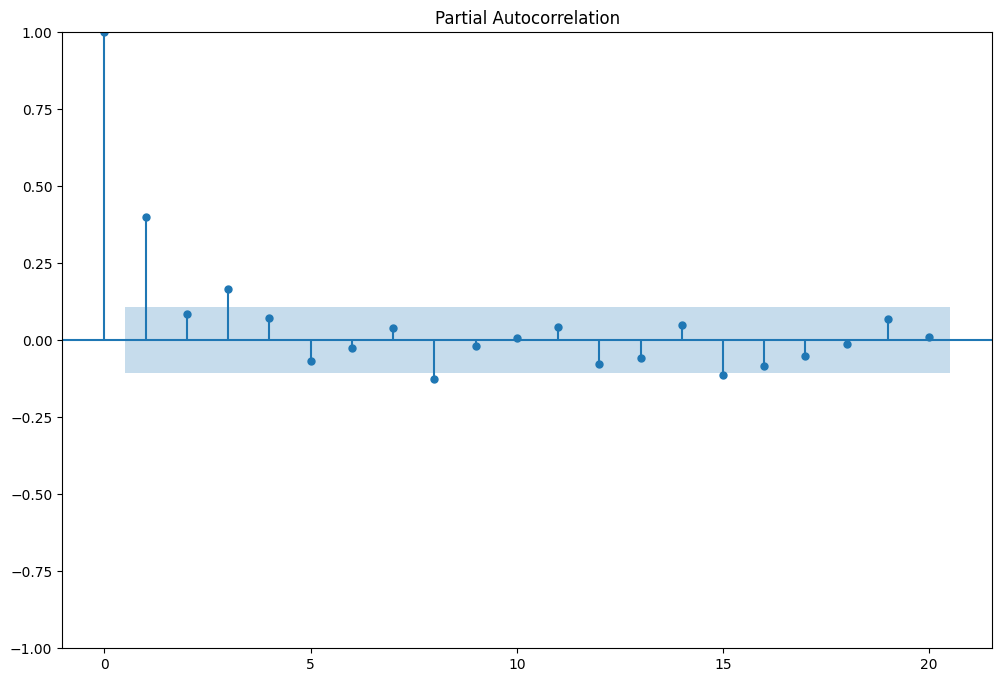

<Figure size 1500x300 with 0 Axes>

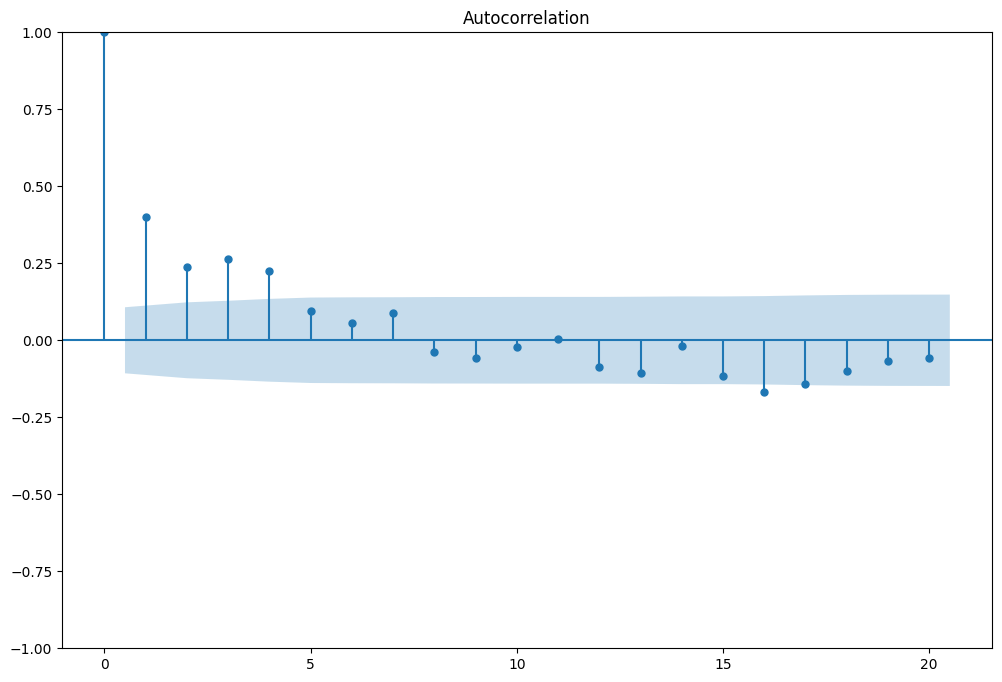

<Figure size 1500x300 with 0 Axes>

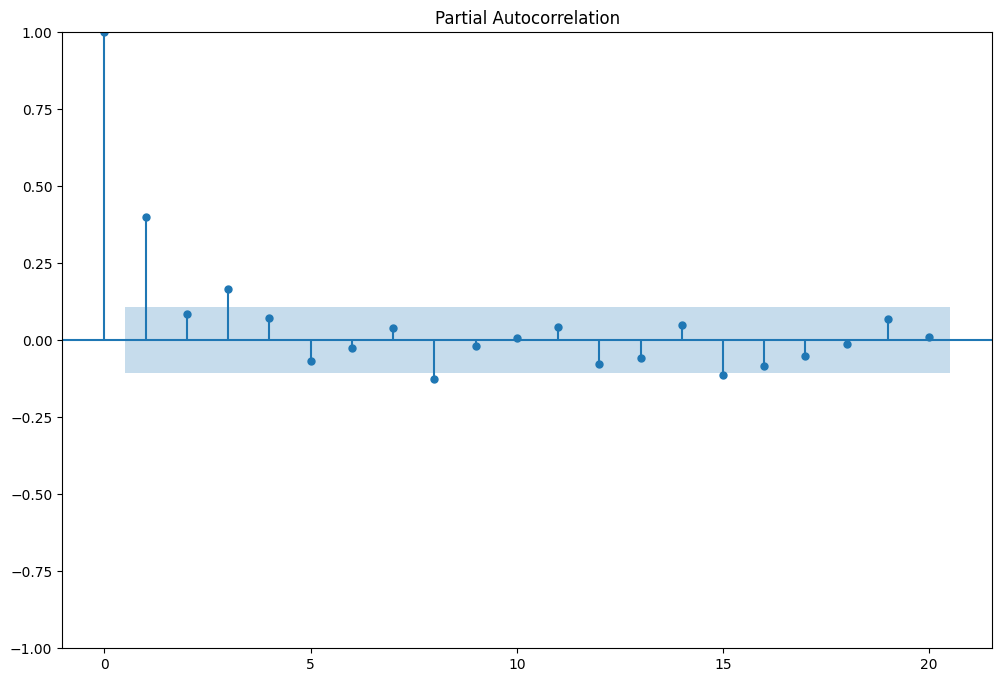

In [204]:
# f, ax = plt.subplots(2,1, figsize=(15, 8))
plt.figure(figsize=(15, 3))
plot_acf(dom_interpolated_df, lags=20)

plt.figure(figsize=(15, 3))
plot_pacf(dom_interpolated_df, lags=20, method='ols')


## - Check Stationarity (Statistical Test)

Properties:
- Constant mean
- Constant variance
- No Seasonality

How to check for it:
- Visual inspection
- Global vs local check
- Statistical tests (ADF, KPSS)
    - ADF tests the presence of a unit root. (H0: not stationary)
    - KPSS tests the absence of a unit root. (H0: stationary)

Possible results of statistical tests:
- Both tests conclude that the series is not stationary -> The series is not stationary
- Both tests conclude that the series is stationary -> The series is stationary
- KPSS indicates stationarity and ADF indicates non-stationarity -> The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.
- KPSS indicates non-stationarity and ADF indicates stationarity -> The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.


Convert non stationary to stationary:
- Differencing (y(t)-y(t-1) -> first order, y(t)-y(t-2) -> second order,…)
- Log operation to smooth exponentially increasing graphs
- Seasonal differencing (Y(t)-Y(t-N))

## - ADF (Augmented Dickey Fuller) Test

In [205]:
dftest = adfuller(dom_interpolated_df, autolag="AIC")
dfoutput = pd.Series(
    dftest[0:4],
    index=[
        "Test Statistic",
        "p-value",
        "# Lags Used",
        "# Observations Used",
    ],
)

print("ADF Test Results:")
print(dfoutput)
if dfoutput[1] > 0.05:
    print("*****The data is not stationary according to the ADF test*****")
else:
    print("*****The data is stationary according to the ADF test*****")

ADF Test Results:

Test Statistic        -6.800024e+00

p-value                2.249404e-09

# Lags Used            2.000000e+00

# Observations Used    3.310000e+02

dtype: float64

*****The data is stationary according to the ADF test*****


/var/folders/kw/dchp08qs3lqgjzpc8kwkl5xr0000gn/T/ipykernel_2585/4215949198.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

  if dfoutput[1] > 0.05:


## - KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test

In [206]:
kpsstest = kpss(dom_interpolated_df, regression="c", nlags="auto")
kpss_output = pd.Series(
    kpsstest[0:3], 
    index=[
        "Test Statistic", 
        "p-value", 
        "# Lags Used"])

print("Results of KPSS Test:")
print(kpss_output)
if kpsstest[1] > 0.05:
    print("*****The data is stationary according to the KPSS test*****")
else:
    print("*****The data is not stationary according to the KPSS test*****")

Results of KPSS Test:

Test Statistic    0.251463

p-value           0.100000

# Lags Used       8.000000

dtype: float64

*****The data is stationary according to the KPSS test*****


/var/folders/kw/dchp08qs3lqgjzpc8kwkl5xr0000gn/T/ipykernel_2585/2579964751.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the

look-up table. The actual p-value is greater than the p-value returned.



  kpsstest = kpss(dom_interpolated_df, regression="c", nlags="auto")


## - Train Test Split

In [207]:
# Split the data into train and test
train = dom_interpolated_df[:-5]
test = dom_interpolated_df[-5:]
test

,Amount
Date,
2018-12-27,597140.0
2018-12-28,475310.0
2018-12-29,572400.0
2018-12-30,370640.0
2018-12-31,511430.0


In [208]:
# Huber loss function
def huber_loss(y_pred, y, delta=1.0):
    huber_mse = 0.5 * (y - y_pred) ** 2
    huber_mae = delta * (np.abs(y - y_pred) - 0.5 * delta)
    return np.where(np.abs(y - y_pred) <= delta, huber_mse, huber_mae)

# ARIMA Model

- We can either use auto_arima to find model order or manually by checking the ACF and PACF plots above.
- The plots suggest (2,0,4)

## - Figure out model order using auto_arima

- p -> AR order
- d -> degree of differencing
- q -> MA order

In [209]:
arima_fit = pm.auto_arima(linear_interpolated_df, start_p=1, start_q=1,supress_warnings=True)
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  334
Model:               SARIMAX(4, 0, 0)   Log Likelihood               -4536.906
Date:                Tue, 12 Sep 2023   AIC                           9085.813
Time:                        14:51:26   BIC                           9108.680
Sample:                    02-01-2018   HQIC                          9094.930
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.804e+05   3.26e+04      5.541      0.000    1.17e+05    2.44e+05
ar.L1          0.3601      0.050      7.265      0.000       0.263       0.457
ar.L2          0.0615      0.053      1.171      0.242      -0.041       0.165
ar.L3          0.1517      0.056      2.725      0.006       0.043       0.261
ar.L4          0.0906      0.055      1.652      0.098      -0.017       0.198
sigma2      3.616e+10      0.324   1.12e+11      0.000    3.62e+10    3.62e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               152.25
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                             0.72
Prob(H) (two-sided):                  0.53   Kurtosis:                         5.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.27e+25. Standard errors may be unstable.
"""

## - Build ARIMA Models and test according

In [210]:
auto_arima_model = ARIMA(train, order=(4, 0, 0)).fit()
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Amount   No. Observations:                  329
Model:                 ARIMA(4, 0, 0)   Log Likelihood               -4474.339
Date:                Tue, 12 Sep 2023   AIC                           8960.678
Time:                        14:51:26   BIC                           8983.455
Sample:                    02-01-2018   HQIC                          8969.764
                         - 12-26-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.034e+05   2.53e+04     19.880      0.000    4.54e+05    5.53e+05
ar.L1          0.3386      0.052      6.506      0.000       0.237       0.441
ar.L2          0.0208      0.053      0.391      0.696      -0.083       0.125
ar.L3          0.1477      0.056      2.627      0.009       0.038       0.258
ar.L4          0.0775      0.055      1.401      0.161      -0.031       0.186
sigma2      3.744e+10      0.125   2.99e+11      0.000    3.74e+10    3.74e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               138.78
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                             0.89
Prob(H) (two-sided):                  0.63   Kurtosis:                         5.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.93e+27. Standard errors may be unstable.
"""

In [211]:
manual_arima_model = ARIMA(train, order=(2, 0, 4)).fit()
manual_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Amount   No. Observations:                  329
Model:                 ARIMA(2, 0, 4)   Log Likelihood               -4473.624
Date:                Tue, 12 Sep 2023   AIC                           8963.248
Time:                        14:51:26   BIC                           8993.616
Sample:                    02-01-2018   HQIC                          8975.363
                         - 12-26-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.034e+05    2.5e+04     20.121      0.000    4.54e+05    5.52e+05
ar.L1          0.4711      0.572      0.824      0.410      -0.650       1.592
ar.L2          0.0522      0.440      0.118      0.906      -0.811       0.915
ma.L1         -0.1308      0.568     -0.230      0.818      -1.243       0.982
ma.L2         -0.0650      0.271     -0.240      0.810      -0.595       0.465
ma.L3          0.1095      0.091      1.203      0.229      -0.069       0.288
ma.L4          0.1398      0.084      1.670      0.095      -0.024       0.304
sigma2      3.774e+10      0.088   4.27e+11      0.000    3.77e+10    3.77e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               128.36
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                             0.85
Prob(H) (two-sided):                  0.66   Kurtosis:                         5.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.88e+26. Standard errors may be unstable.
"""

- Make Predictions on Test set

In [212]:
auto_pred = auto_arima_model.predict(start=test.index[0], end=test.index[-1], typ='levels')
manual_pred = manual_arima_model.predict(start=test.index[0], end=test.index[-1], typ='levels')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.

  warnings.warn(msg, FutureWarning)


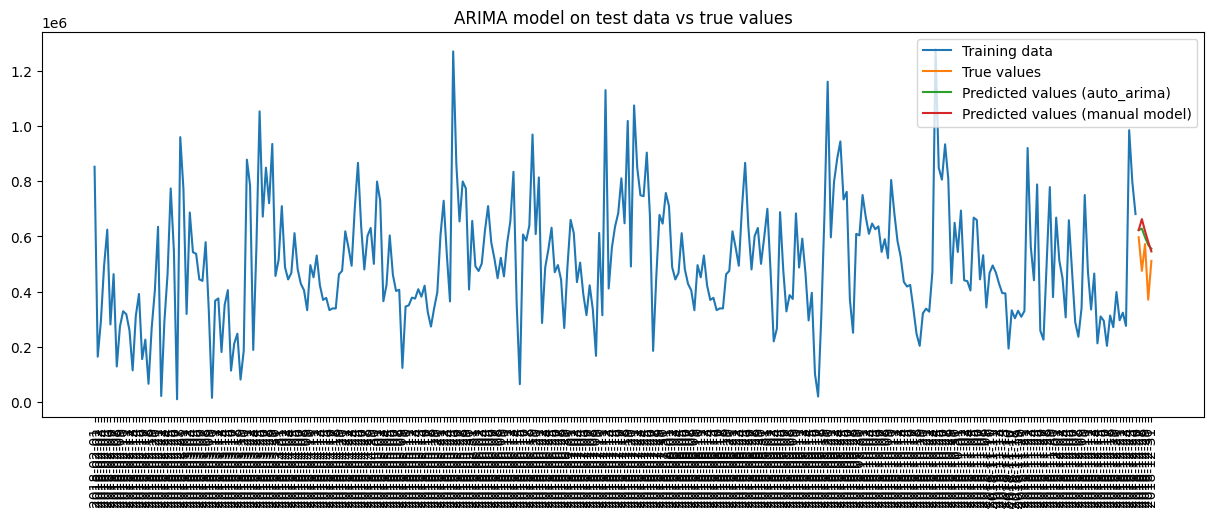

In [213]:
plt.figure(figsize=(15, 5))
plt.plot(train, label='Training data')
plt.plot(test, label='True values')
plt.plot(auto_pred, label='Predicted values (auto_arima)')
plt.plot(manual_pred, label='Predicted values (manual model)')

plt.xticks(linear_interpolated_df.index.values, rotation=90)
plt.legend()
plt.title('ARIMA model on test data vs true values')
plt.show()

- Calculate MSE to check test error

In [214]:
results = pd.DataFrame()

mape = round(metrics.mean_absolute_percentage_error(test, auto_pred),2)
rmse = round(sqrt(metrics.mean_squared_error(test, auto_pred)),2)
huber = round(np.mean(huber_loss(auto_pred.values, test.values, delta=1)), 4)

tempResults = pd.DataFrame({'Method':['ARMA (4,0)'], 
                            'RMSE': [rmse],
                            'MAPE': [mape],
                            'Huber': [huber]})

results = pd.concat([results, tempResults])

mape = round(metrics.mean_absolute_percentage_error(test, manual_pred),2)
rmse = round(sqrt(metrics.mean_squared_error(test, manual_pred)),2)
huber = round(np.mean(huber_loss(manual_pred.values, test.values, delta=1)), 4)

tempResults = pd.DataFrame({'Method':['ARMA (2,4)'], 
                            'RMSE': [rmse],
                            'MAPE': [mape],
                            'Huber': [huber]})

results = pd.concat([results, tempResults])
results

,Method,RMSE,MAPE,Huber
0,"ARMA (4,0)",115000.18,0.21,96517.8184
0,"ARMA (2,4)",129139.15,0.23,108613.0438


## - Rolling Forecasting applied to ARIMA

In [215]:
arma_rolling_predictions = test.copy()
predictions = []

for train_end in test.index:
    train_data = dom_interpolated_df[:train_end - timedelta(days=1)]
    model = ARIMA(train_data, order=(4, 0, 0))
    model_fit = model.fit()
    pred = model_fit.forecast()
    predictions.append(pred[0])
print(predictions)
print(test.index)
arma_rolling_predictions = pd.Series(predictions, index=test.index)


[623294.8929952789, 619763.3461652622, 543528.064838379, 553341.7245651031, 462724.70522585226]

DatetimeIndex(['2018-12-27', '2018-12-28', '2018-12-29', '2018-12-30',

               '2018-12-31'],

              dtype='datetime64[ns]', name='Date', freq='D')


/var/folders/kw/dchp08qs3lqgjzpc8kwkl5xr0000gn/T/ipykernel_2585/3601322460.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

  predictions.append(pred[0])

/var/folders/kw/dchp08qs3lqgjzpc8kwkl5xr0000gn/T/ipykernel_2585/3601322460.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

  predictions.append(pred[0])

/var/folders/kw/dchp08qs3lqgjzpc8kwkl5xr0000gn/T/ipykernel_2585/3601322460.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

In [216]:
arma_rolling_predictions

Date
2018-12-27    623294.892995
2018-12-28    619763.346165
2018-12-29    543528.064838
2018-12-30    553341.724565
2018-12-31    462724.705226
Freq: D, dtype: float64

Date

2018-12-27    623294.892995

2018-12-28    619763.346165

2018-12-29    543528.064838

2018-12-30    553341.724565

2018-12-31    462724.705226

Freq: D, dtype: float64

[[597140.]

 [475310.]

 [572400.]

 [370640.]

 [511430.]]


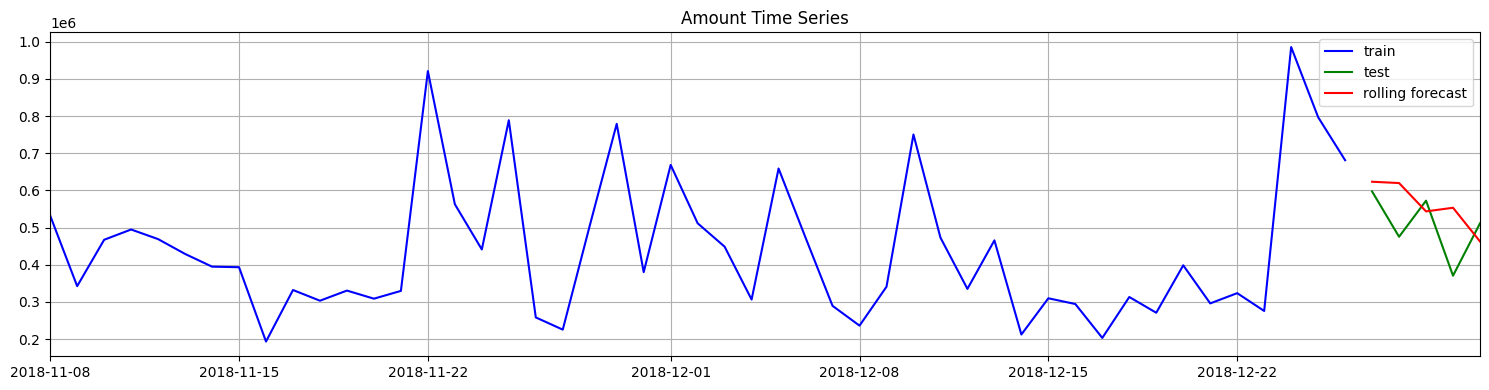

In [217]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 4))
print(arma_rolling_predictions)
print(test.values)
plt.plot(train[280:], label='train', color='blue')
plt.plot(test, label='test', color='green')
plt.plot(arma_rolling_predictions.index, arma_rolling_predictions.values, label='rolling forecast', color='red')
ax.set_xlim([linear_interpolated_df.index[280], linear_interpolated_df.index[-1]])
ax.set_title('Amount Time Series')
plt.tight_layout()
plt.grid()
plt.legend()
plt.show()

In [218]:
mape = round(metrics.mean_absolute_percentage_error(test, arma_rolling_predictions),2)
rmse = round(sqrt(metrics.mean_squared_error(test, arma_rolling_predictions)),2)
huber = round(np.mean(huber_loss(arma_rolling_predictions.values, test.values, delta=1)), 4)

tempResults = pd.DataFrame({'Method':['ARMA (4,0) with rolling forecasting'], 
                            'RMSE': [rmse],
                            'MAPE': [mape],
                            'Huber': [huber]})

results = pd.concat([results, tempResults])
results

,Method,RMSE,MAPE,Huber
0,"ARMA (4,0)",115000.18,0.21,96517.8184
0,"ARMA (2,4)",129139.15,0.23,108613.0438
0,"ARMA (4,0) with rolling forecasting",107830.02,0.20,91203.7748


# LSTM

- Scale data

In [219]:
dataset = dom_interpolated_df.copy()
dataset = pd.DataFrame(dataset)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

- Split train test data

In [220]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i + look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

# split into train and test sets
train_size = int(len(dataset) * 0.97)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [244]:
test

,Amount
Date,
2018-12-27,597140.0
2018-12-28,475310.0
2018-12-29,572400.0
2018-12-30,370640.0
2018-12-31,511430.0


- create and fit the LSTM network


In [221]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
#### **Prediction**
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict


Epoch 1/100

320/320 - 1s - loss: 0.0614 - 710ms/epoch - 2ms/step

Epoch 2/100

320/320 - 0s - loss: 0.0255 - 136ms/epoch - 424us/step

Epoch 3/100

320/320 - 0s - loss: 0.0250 - 132ms/epoch - 412us/step

Epoch 4/100

320/320 - 0s - loss: 0.0250 - 132ms/epoch - 413us/step

Epoch 5/100

320/320 - 0s - loss: 0.0248 - 132ms/epoch - 413us/step

Epoch 6/100

320/320 - 0s - loss: 0.0246 - 132ms/epoch - 412us/step

Epoch 7/100

320/320 - 0s - loss: 0.0247 - 132ms/epoch - 411us/step

Epoch 8/100

320/320 - 0s - loss: 0.0245 - 130ms/epoch - 407us/step

Epoch 9/100

320/320 - 0s - loss: 0.0245 - 131ms/epoch - 408us/step

Epoch 10/100

320/320 - 0s - loss: 0.0243 - 131ms/epoch - 411us/step

Epoch 11/100

320/320 - 0s - loss: 0.0244 - 131ms/epoch - 411us/step

Epoch 12/100

320/320 - 0s - loss: 0.0241 - 130ms/epoch - 408us/step

Epoch 13/100

320/320 - 0s - loss: 0.0241 - 132ms/epoch - 413us/step

Epoch 14/100

320/320 - 0s - loss: 0.0242 - 130ms/epoch - 407us/step

Epoch 15/100

320/320 - 0s - lo

[[411000.03]

 [395362.06]

 [661645.1 ]

 [651670.7 ]

 [587256.44]

 [543337.44]

 [489338.22]

 [515129.8 ]]


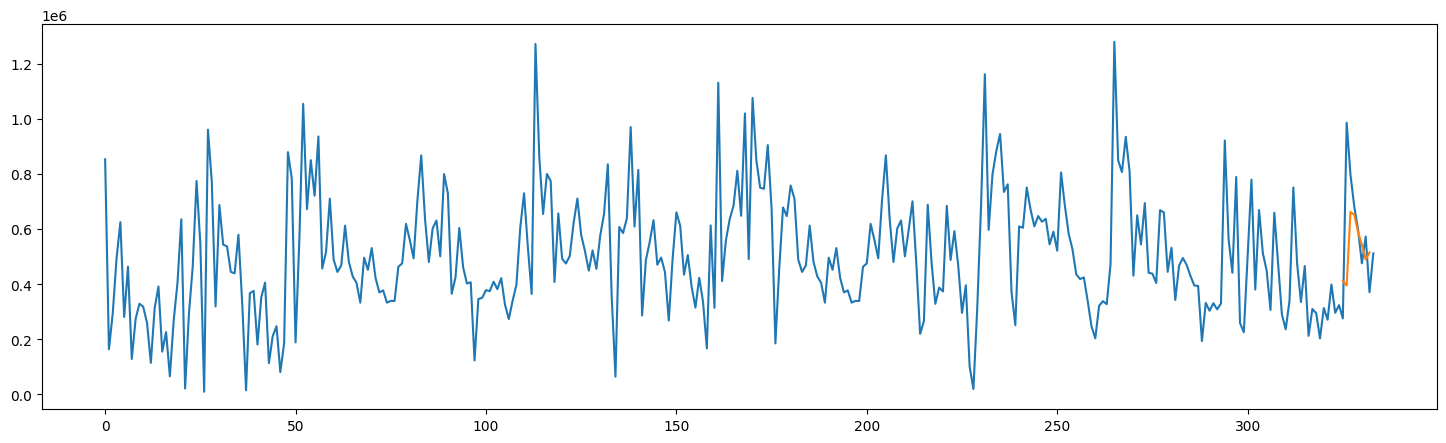

In [245]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back* 2)+1:len(dataset)-1, :] = testPredict
print(testPredict)
# plot baseline and predictions
plt.figure(figsize=(18, 5))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(testPredictPlot)
plt.show()

In [246]:

lstm_residuals = testY[0] - testPredict.T[0]
mape = round(np.mean(abs(lstm_residuals[-5:] / testY[0][-5:])), 2)
rmse = round(np.sqrt(np.mean(lstm_residuals[-5:] ** 2)),1)
huber = round(np.mean(huber_loss(testPredict.T[0][-5:], testY[0][-5:], delta=1)), 1)

tempResults = pd.DataFrame({'Method':['Long Short-term Memory (LSTM)'], 
                            'RMSE': [rmse],
                            'MAPE': [mape],
                            'Huber': [huber]})

results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE', 'Huber']]

# - Holt Winter Exponential Smoothing Method

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.

  warnings.warn(


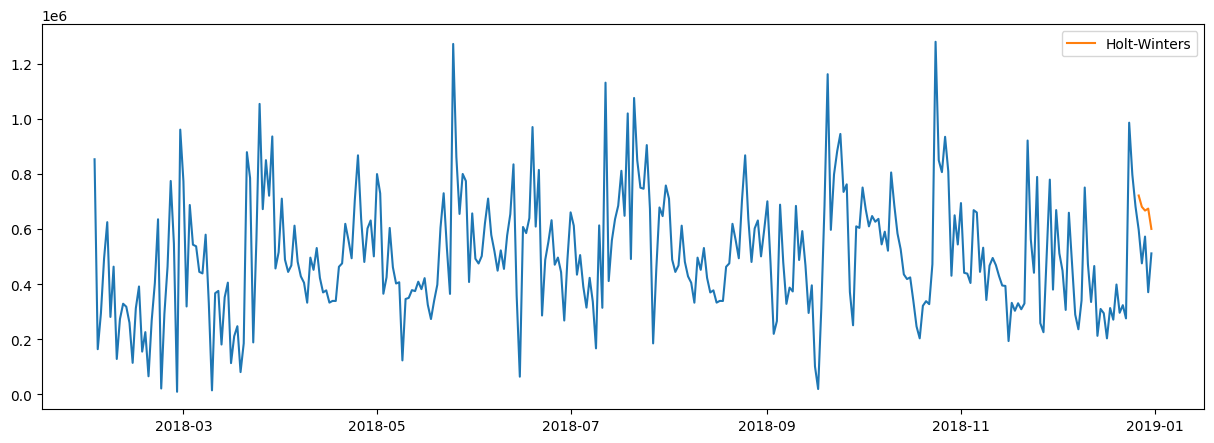

In [247]:
# Split the data into train and test
train = dom_interpolated_df[:-5]
test = dom_interpolated_df[-5:]
plt.figure(figsize=(15, 5))
hw_model =  ExponentialSmoothing(np.asarray(train) ,seasonal_periods=24 ,trend='add', seasonal='add')
model_fit = hw_model.fit(optimized=True)
y_hat_hw = test.copy()
hw_test = pd.DataFrame(y_hat_hw)
hw_test['pred'] = model_fit.forecast(len(test))
plt.plot(dom_interpolated_df.index,dom_interpolated_df, label='')
# plt.plot(dom_interpolated_df.index[-5:],test, label='Test')
plt.plot(dom_interpolated_df.index[-5:],hw_test['pred'], label='Holt-Winters')
plt.legend(loc='best')
plt.show()

In [248]:
mape = round(metrics.mean_absolute_percentage_error(test, hw_test['pred']),2)
rmse = round(sqrt(metrics.mean_squared_error(test, hw_test['pred'])),2)
huber = round(np.mean(huber_loss(hw_test['pred'].values, test.values, delta=1)), 4)

tempResults = pd.DataFrame({'Method':['Holt Winters'], 
                            'RMSE': [rmse],
                            'MAPE': [mape],
                            'Huber': [huber]})

results = pd.concat([results, tempResults])
results

,Method,RMSE,MAPE,Huber
0,"ARMA (4,0)",115000.00,0.21,96518.0000
0,"ARMA (2,4)",129139.00,0.23,108613.0000
0,"ARMA (4,0) with rolling forecasting",107830.00,0.20,91204.0000
0,Long Short-term Memory (LSTM),81702.00,0.15,67004.0000
0,Holt Winters,182283.00,0.36,163086.0000
0,Long Short-term Memory (LSTM),81701.60,0.15,67003.9000
0,Holt Winters,182282.85,0.36,163086.3639


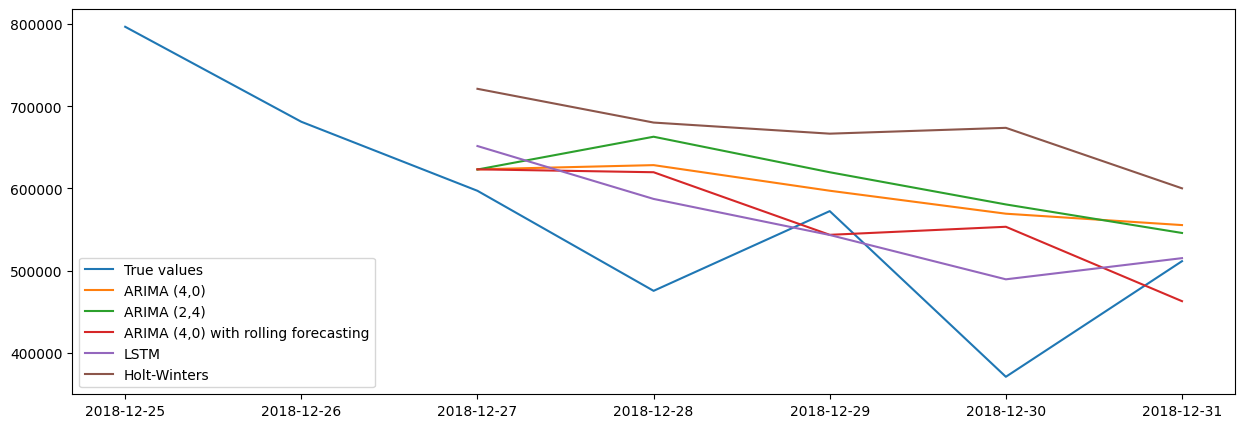

In [255]:
# plot all results
plt.figure(figsize=(15, 5))
plt.plot(dom_interpolated_df.index[-7:],dom_interpolated_df[-7:], label='True values')
plt.plot(auto_pred.index, auto_pred, label='ARIMA (4,0)')
plt.plot(manual_pred.index, manual_pred, label='ARIMA (2,4)')
plt.plot(arma_rolling_predictions.index, arma_rolling_predictions, label='ARIMA (4,0) with rolling forecasting')
plt.plot(dom_interpolated_df.index[-5:],testPredict[-5:], label='LSTM')
plt.plot(hw_test.index, hw_test['pred'], label='Holt-Winters')
plt.legend(loc='best')
plt.show()


In [234]:
results['Huber'] = round(results['Huber'])
results['RMSE']= round(results['RMSE'])
results

,Method,RMSE,MAPE,Huber
0,"ARMA (4,0)",115000.0,0.21,96518.0
0,"ARMA (2,4)",129139.0,0.23,108613.0
0,"ARMA (4,0) with rolling forecasting",107830.0,0.20,91204.0
0,Long Short-term Memory (LSTM),81702.0,0.15,67004.0
0,Holt Winters,182283.0,0.36,163086.0


In [256]:
predictions = pd.DataFrame()
predictions['Date'] = dom_interpolated_df.index[-5:]
predictions['True values'] = dom_interpolated_df[-5:].values
predictions['ARIMA (4,0)'] = auto_pred.values
predictions['ARIMA (2,4)'] = manual_pred.values
predictions['ARIMA (4,0) with rolling forecasting'] = arma_rolling_predictions.values
predictions['LSTM'] = testPredict[-5:]
predictions['Holt-Winters'] = hw_test['pred'].values
predictions.to_csv('predictions.csv')
predictions

,Date,True values,"ARIMA (4,0)","ARIMA (2,4)","ARIMA (4,0) with rolling forecasting",LSTM,Holt-Winters
0,2018-12-27,597140.0,623294.892995,623082.427734,623294.892995,651670.68750,721362.572482
1,2018-12-28,475310.0,628416.594587,663006.853683,619763.346165,587256.43750,680261.872258
2,2018-12-29,572400.0,597236.295793,619741.975573,543528.064838,543337.43750,666733.791281
3,2018-12-30,370640.0,569258.325377,580543.545959,553341.724565,489338.21875,673833.565944
4,2018-12-31,511430.0,555400.718109,545791.673418,462724.705226,515129.81250,600162.517658
